In [8]:
import tensorflow as tf
keras = tf.keras
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [9]:
# %run ../src/acc_df.py
# Ac = Acc_data('../data/cleaned/coll_coord.csv')
# acc = Ac.get_all_coll() #['']

### 1. Turn it into a time series of weeks

In [10]:
week_numbers = pd.read_csv('../../data/cleaned/weekseries_05_18.csv')

In [11]:
week_numbers.head(2),week_numbers.tail(2)

(           ds  acc_nr
 0  2005-01-02     275
 1  2005-01-09     308,              ds  acc_nr
 729  2018-12-23     234
 730  2018-12-30     150)

In [12]:
acc_nr_bw = week_numbers.acc_nr.values #[:100]
len(acc_nr_bw)

731

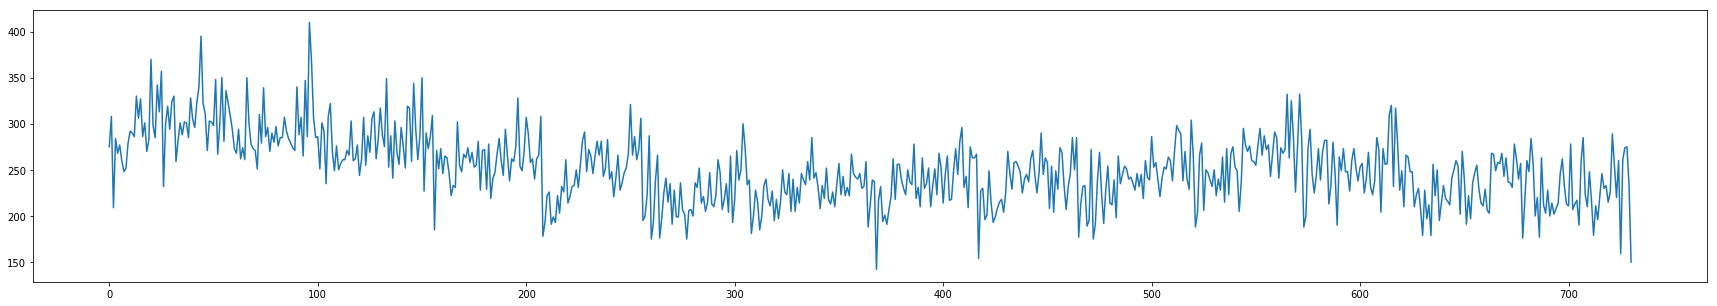

In [13]:
fig, ax = plt.subplots(figsize=(30,5))
ax.plot(week_numbers.index.values, acc_nr_bw)

#### Windowize and split

In [14]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

In [15]:
# windowize_data(week_numbers.index.values,20)

In [16]:
def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [17]:
n_prev = 50
x_train, x_test, y_train, y_test = split_and_windowize(acc_nr_bw, n_prev, fraction_test=0.01)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((575, 50, 1), (56, 50, 1), (575,), (56,))

#### Model

In [21]:
model = keras.Sequential()
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(60, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error')

### Train

In [22]:
model.fit(x_train, y_train, batch_size=32, epochs=5000)

Train on 575 samples
Epoch 1/5000
575/575 [==============================] - 3s 5ms/sample - loss: 61465.3173
Epoch 2/5000
575/575 [==============================] - 1s 1ms/sample - loss: 59256.6836
Epoch 3/5000
575/575 [==============================] - 1s 1ms/sample - loss: 58514.4496
Epoch 4/5000
575/575 [==============================] - 1s 1ms/sample - loss: 57919.5489
Epoch 5/5000
575/575 [==============================] - 1s 1ms/sample - loss: 57374.3430
Epoch 6/5000
575/575 [==============================] - 1s 1ms/sample - loss: 56846.2508
Epoch 7/5000
575/575 [==============================] - 1s 1ms/sample - loss: 56326.0825
Epoch 8/5000
575/575 [==============================] - 1s 1ms/sample - loss: 55812.3187
Epoch 9/5000
575/575 [==============================] - 1s 1ms/sample - loss: 55300.9220
Epoch 10/5000
575/575 [==============================] - 1s 1ms/sample - loss: 54792.1003
Epoch 11/5000
575/575 [==============================] - 1s 1ms/sample - loss: 54287.018

In [25]:
y_pred = model.predict(x_test)
y_pred[:5]

array([[218.346  ],
       [254.16476],
       [220.72502],
       [210.2664 ],
       [200.90306]], dtype=float32)

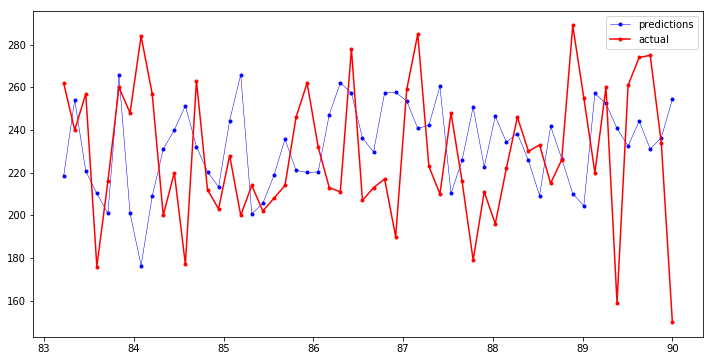

In [26]:
n_pts = len(acc_nr_bw)
t = np.linspace(0, 15 * 6, n_pts)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.-', label='actual')
ax.legend()

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred,y_test)

1707.1637777839912

In [29]:
import datetime as dt
filename = 'models/lstm_8_{}_{}'.format(dt.datetime.now().day,dt.datetime.now().minute)
model.save(filename)

#### next try